# 210429 Simple overlap plots

In [1]:
using Mmap
using Printf

In [2]:
using JSON
using CSV
using DataFrames
using FilePathsBase
using FilePathsBase: /
using ProgressMeter
using Clustering

In [3]:
using Midas.Pairwise: npairs, iterpairs
using TriMatrices

In [4]:
using PlotlyJS
using ColorSchemes

using MidasPlots
using MidasPlots.Plotly

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1129180753425227079\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-18145006111382484368\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1129180753425227079\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## Setup

In [5]:
ENV["COLUMNS"] = 400

400

In [6]:
DATESTR = "210429"
NBNAME = "$DATESTR-simple-overlap-plots"

"210429-simple-overlap-plots"

In [7]:
infiles = Dict(
    :distances => p"../../data/intermediate/200727-find-overlaps/genome-pw-distances.raw-float32",
    :db => p"../../data/intermediate/210401-database-v2-fix-species-overlaps/210424-compile-fixes/",
    :overlaps => p"data-intermediate/210428-find-remaining-overlaps/",
);

In [8]:
reports_out = p"reports" / NBNAME
isdir(reports_out) || mkdir(reports_out);

## Load data

### Database

In [9]:
taxa = DataFrame(CSV.File(infiles[:db] / "taxa.csv"));

In [10]:
genome_assignments = Vector{Int}(open(JSON.parse, infiles[:db] / "genome-taxon-assignments.json"))
ngenomes = length(genome_assignments)

50752

In [11]:
tid_to_tidx = Dict(id => i for (i, id) in enumerate(taxa[!, :id]))

taxon_index(tid::Integer) = tid_to_tidx[tid]
taxon_index(tids::AbstractVector{<:Integer}) = taxon_index.(tids)

lookup_tid(tid, cols=:) = taxa[tid_to_tidx[tid], cols]

lookup_tid (generic function with 2 methods)

### Distances

In [12]:
pw_data = Mmap.mmap(open(infiles[:distances]), Vector{Float32}, (npairs(ngenomes),));

pw_dists = TriMatrix(TriSymmetric{false}(), ngenomes, pw_data);

### Overlaps

In [13]:
overlaps = let
    data = open(JSON.parse, infiles[:overlaps] / "overlaps.json")
    
    map(data) do item
        item["src_taxid"] => collect(zip(item["src_leaf_taxids"], item["dst_leaf_taxids"], item["distances"]))
    end |> Dict
end

taxa[!, :noverlaps] = [haskey(overlaps, id) ? length(overlaps[id]) : 0 for id in taxa[!, :id]]
taxa[!, :has_overlaps] = map(>(0), taxa.noverlaps)
;

In [14]:
let
    data = open(JSON.parse, infiles[:overlaps] / "calculated.json")
    data2 = Dict(item["id"] => item for item in data)
    
    cols = [
        (:is_root, Bool),
        (:leaves, Vector{Int}),
        (:genomes, Vector{Int}),
        (:diameter, Float32),
        (:threshold, Float32),
        (:max_leaf_threshold, Float32),
        (:min_inter_src, Int),
        (:min_inter_dst, Int),
        (:min_inter_dist, Float32),
    ]
    
    for (col, T) in cols
        taxa[!, col] = collect(T, data2[id][string(col)] for id in taxa[!, :id])
    end
end

## Setup

In [15]:
internal_taxa = filter(:is_leaf => !, taxa, view=true);

### Leaf data

In [16]:
leaf_tidxs = findall(taxa[!, :is_leaf])
leaf_tids = taxa[leaf_tidxs, :id]
nleaves = length(leaf_tidxs)

@assert issetequal(leaf_tids, setdiff(Set(genome_assignments), 0))

leaf_id_to_index = Dict(tid => i for (i, tid) in enumerate(leaf_tids))
taxa[!, :leaf_idxs] = [[leaf_id_to_index[id] for id in leaves] for leaves in taxa.leaves]
leaf_gidxs = taxa[leaf_tidxs, :genomes]

length(leaf_tids)

1445

In [17]:
leaf_pw_min_dists = zeros(eltype(pw_dists), nleaves, nleaves)
leaf_pw_max_dists = zeros(eltype(pw_dists), nleaves, nleaves)

@showprogress for (i, j) in iterpairs(nleaves, true)
    dmat = view(pw_dists, leaf_gidxs[i], leaf_gidxs[j])
    leaf_pw_min_dists[i, j] = leaf_pw_min_dists[j, i] = minimum(dmat)
    leaf_pw_max_dists[i, j] = leaf_pw_max_dists[j, i] = maximum(dmat)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:249:07


### Plotting

In [18]:
taxa[!, :plot_label] = [string(row.id, " ", row.name) for row in eachrow(taxa)];

In [19]:
let
    palette = Cycler(ColorSchemes.colorschemes[:Set1_8].colors)
    style = Style(global_trace=attr(
        marker_color=palette,
        line_color=palette,
    ))
    use_style!(style)
end;

In [20]:
function overlap_traces(f)
    gb = groupby(internal_taxa, :has_overlaps)
    
    trace1 = f(false, gb[(true,)])
    trace2 = f(true, gb[(false,)])
    
    haskey(trace1, :name) || (trace1[:name] = "Has overlaps")
    haskey(trace2, :name) || (trace2[:name] = "No overlaps")
    
    return [trace1, trace2]
end

overlap_traces (generic function with 1 method)

In [21]:
saveplot(plt::Plot, name) = savefig(plt, string(reports_out / "$DATESTR-$name.html"))

saveplot (generic function with 1 method)

## Plots

### Diameters

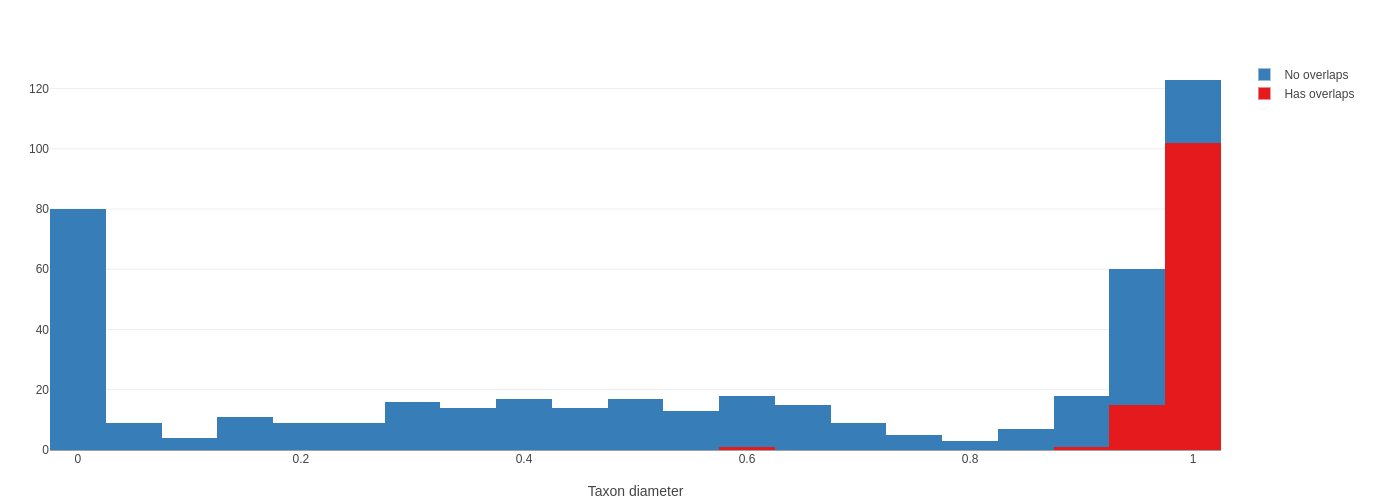

In [22]:
let
    traces = overlap_traces() do has_overlaps, df
        histogram(
            x=df.diameter,
            nbinsx=20,
            mode=:markers,
        )
    end
    
    layout = Layout(
        hovermode=:closest,
        barmode=:stack,
        xaxis_title_text="Taxon diameter",
    )
    
    plt = Plot(traces, layout)
    saveplot(plt, "internal-taxa-diameters-histogram")
    plot(plt)
end

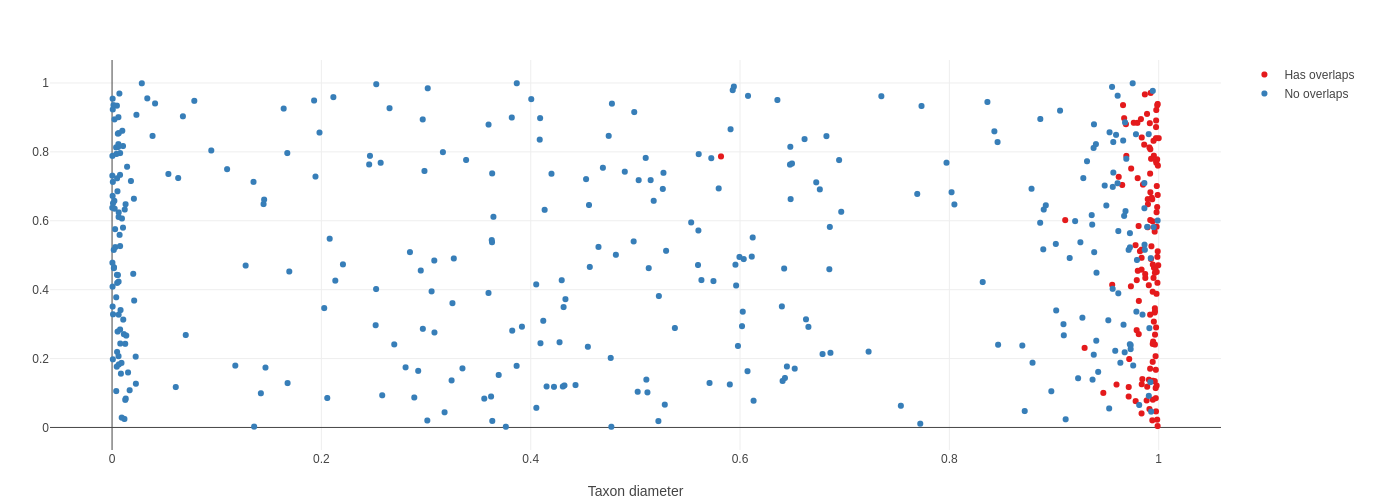

In [23]:
let
    traces = overlap_traces() do has_overlaps, df
        scatter(
            df,
            x=:diameter,
            y=rand(nrow(df)),
            text=:plot_label,
            mode=:markers,
            hoverinfo="x+text"
        )
    end
    
    layout = Layout(
        hovermode=:closest,
        xaxis_title_text="Taxon diameter",
    )
    
    plt = Plot(traces, layout)
    saveplot(plt, "internal-taxa-diameters-scatter")
    plot(plt)
end

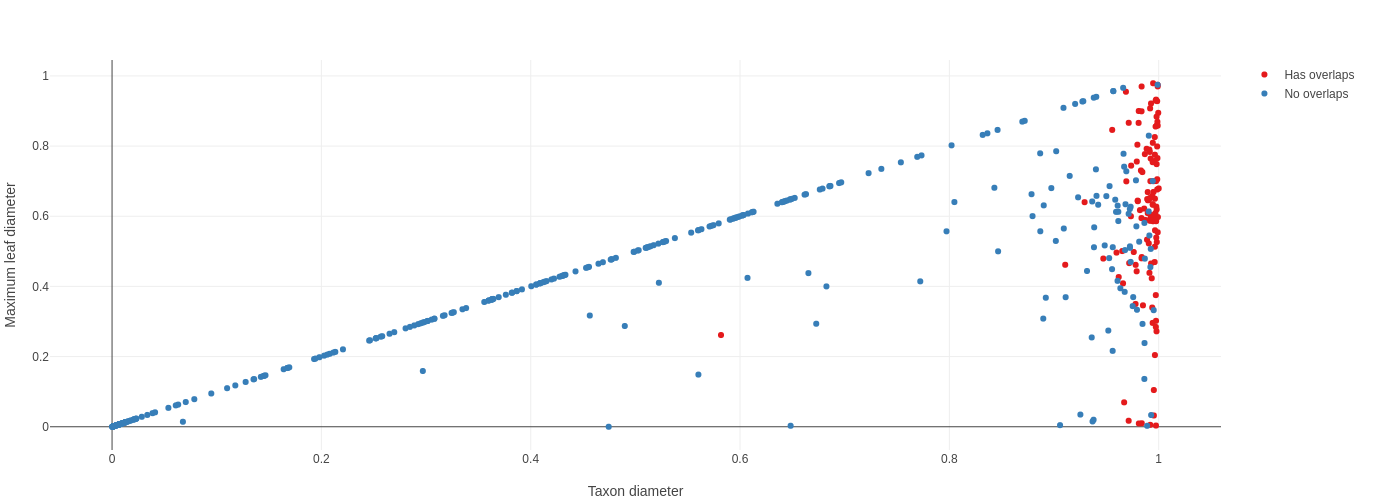

In [24]:
let
    traces = overlap_traces() do has_overlaps, df
        scatter(
            df,
            x=:diameter,
            y=:max_leaf_threshold,
            text=:plot_label,
            mode=:markers,
        )
    end
    
    layout = Layout(
        hovermode=:closest,
        xaxis_title_text="Taxon diameter",
        yaxis_title_text="Maximum leaf diameter",
    )
    
    plt = Plot(traces, layout)
    saveplot(plt, "internal-taxa-diameter-leaf-threshold")
    plot(plt)
end

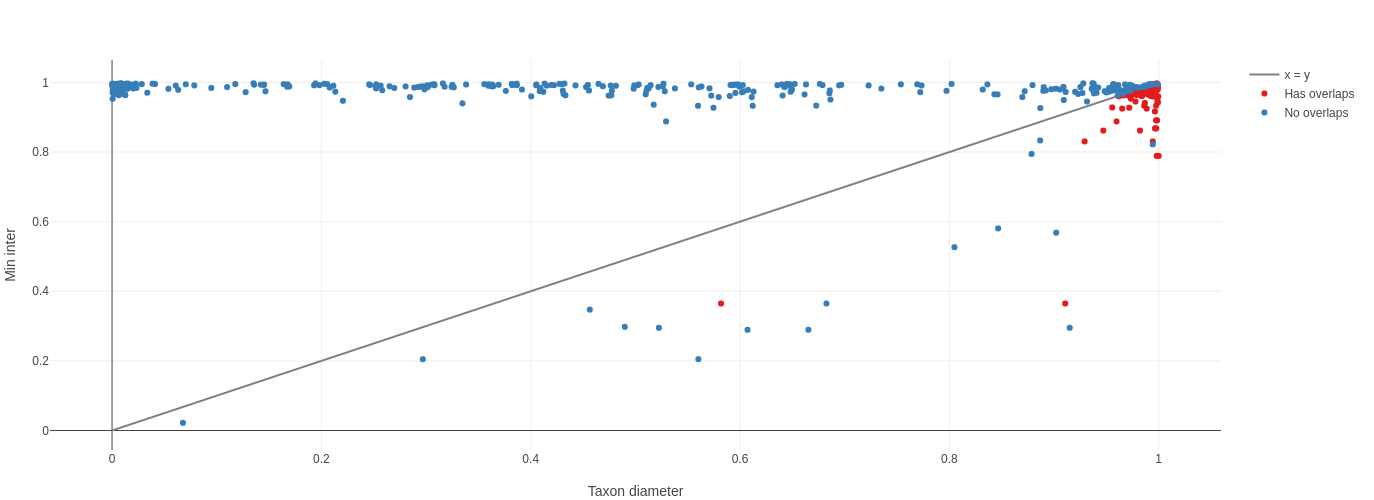

In [25]:
let
    traces = overlap_traces() do has_overlaps, df
        scatter(
            df,
            x=:diameter,
            y=:min_inter_dist,
            text=[
                @sprintf("%s<br>%s → %s", row.plot_label, lookup_tid(row.min_inter_src, :plot_label), lookup_tid(row.min_inter_dst, :plot_label))
                for row in eachrow(df)
            ],
            mode=:markers,
        )
    end
    
    pushfirst!(traces, scatter(
        x=[0, 1],
        y=[0, 1],
        name="x = y",
        line_color="grey",
        marker_color="grey",
        mode=:lines,
    ))
    
    layout = Layout(
        hovermode=:closest,
        xaxis_title_text="Taxon diameter",
        yaxis_title_text="Min inter",
    )
    
    plt = Plot(traces, layout)
    saveplot(plt, "internal-taxa-diameter-min-inter")
    plot(plt)
end

### Heatmaps

In [26]:
function overlap_heatmaps(tid; nmax=50, mark_overlaps=true)
    row = lookup_tid(tid)
    leaf_ids = copy(row.leaves)
    leaf_idxs = copy(row.leaf_idxs)
    leaf_overlaps = overlaps[tid]
    
    dst_ids = unique(dst for (src, dst, d) in leaf_overlaps)
    dst_idxs = [leaf_id_to_index[id] for id in dst_ids]
    
    # Cap number of destination taxa
    if length(dst_ids) > nmax
        @warn "$(length(dst_ids)) dst. species, truncating at $nmax"
        resize!(dst_ids, nmax)
        resize!(dst_idxs, nmax)
    end
    
    # Permute according to hierarchical clustering dendrogram
    leaf_perm = hclust(leaf_pw_max_dists[leaf_idxs, leaf_idxs], linkage=:average).order
    permute!(leaf_ids, leaf_perm)
    permute!(leaf_idxs, leaf_perm)
    dst_perm = hclust(leaf_pw_max_dists[dst_idxs, dst_idxs], linkage=:average).order
    permute!(dst_ids, dst_perm)
    permute!(dst_idxs, dst_perm)
    
    leaf_names = [lookup_tid(id, :plot_label) for id in leaf_ids]
    dst_names = [lookup_tid(id, :plot_label) for id in dst_ids]
    
    # Heatmaps
    hm1 = heatmap(
        name="Max Intra",
        z=leaf_pw_max_dists[leaf_idxs, leaf_idxs],
        x=leaf_names,
        y=leaf_names,
        xaxis="x",
        coloraxis="coloraxis",
    )
    hm2 = heatmap(
        name="Min Inter",
        z=leaf_pw_min_dists[dst_idxs, leaf_idxs],
        x=dst_names,
        y=leaf_names,
        xaxis="x2",
        coloraxis="coloraxis",
    )
    colorrange = extrema(hm2[:z])
    traces = [hm1, hm2]
    
    # Overlap dots
    if mark_overlaps
        push!(traces, scatter(
            x=[lookup_tid(dst, :plot_label) for (src, dst, d) in leaf_overlaps],
            y=[lookup_tid(src, :plot_label) for (src, dst, d) in leaf_overlaps],
            xaxis="x2",
            mode=:markers,
            marker_color="red",
            hoverinfo=:skip,
        ))
    end
    
    # X axes
    x1 = attr(
        title_text="Max Intra",
        showticklabels=false,
        ticks="",
        scaleanchor="y",
        constraintoward=:right,
        constrain=:domain,
        
    )
    x2 = attr(
        title_text="Min inter",
        showticklabels=false,
        ticks="",
        scaleanchor="y",
        constraintoward=:left,
        constrain=:domain,
    )
    MidasPlots.Plotly.subplot_axes!(
        [x1, x2],
        length.([leaf_idxs, dst_idxs]),
        sep=0.5,
    )
    
    # Layout
    layout = Layout(
        xaxis=x1,
        xaxis2=x2,
        yaxis=attr(
            visible=false,
        ),
        title_text=@sprintf("%s (diameter = %.3f)", row.name, row.diameter),
        coloraxis=attr(
#             cmin=colorrange[1],
#             cmax=colorrange[2],
            colorscale="Viridis"
        ),
    )
    
    return Plot(traces, layout)
end

overlap_heatmaps (generic function with 1 method)

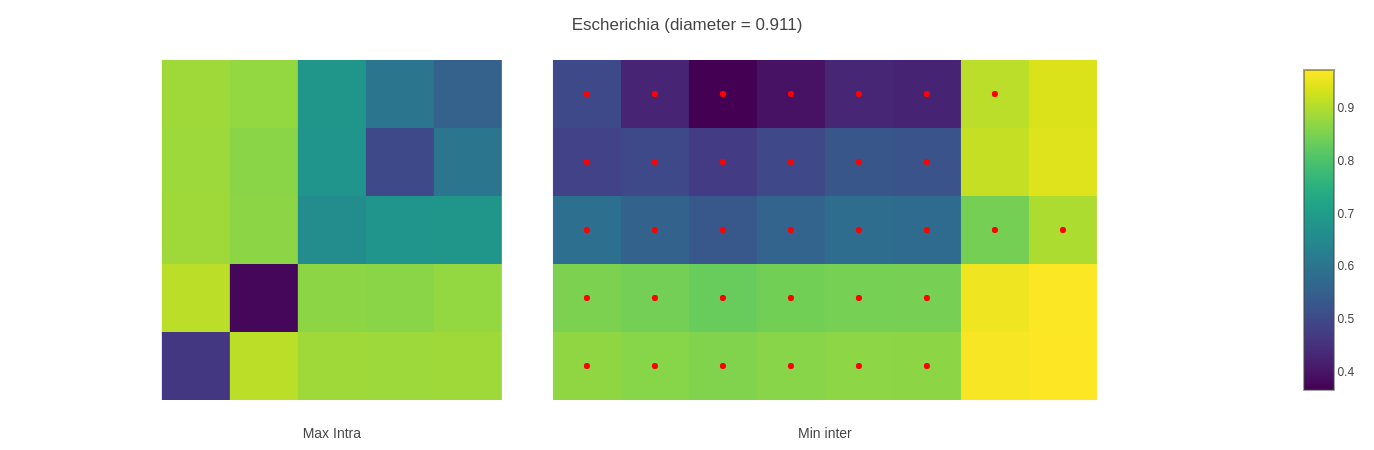

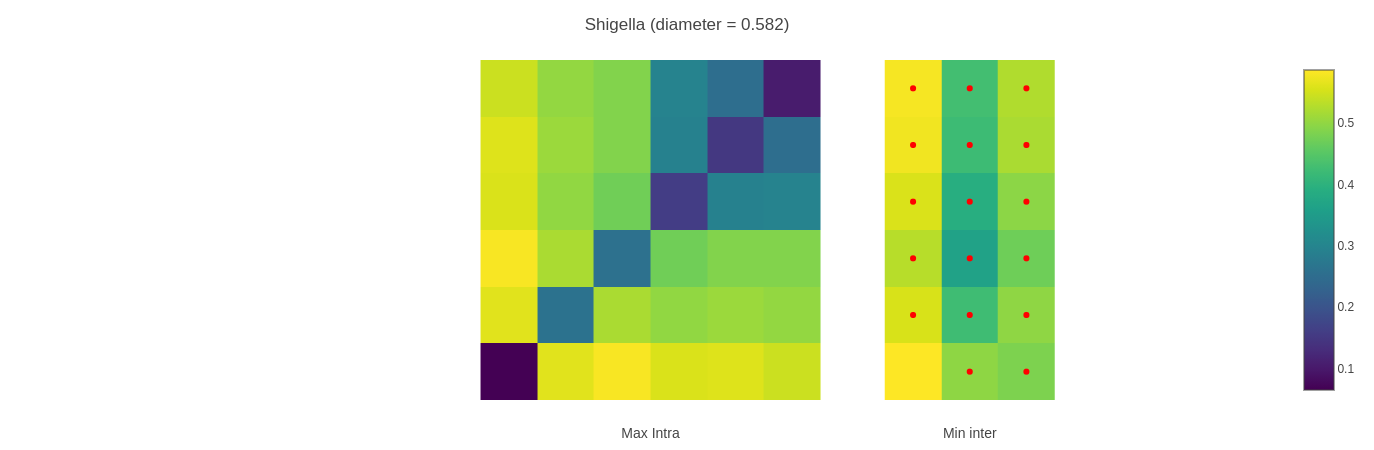

In [27]:
# Escherichia and Shigella
for tid in [149, 161]
    row = lookup_tid(tid)
    plt = overlap_heatmaps(tid)
    saveplot(plt, "$(row.name)-overlap-heatmaps")
    display(plt)
end